# Milestone 4: Marketstack Historical Data API

In [92]:
# Import libaries
import http.client
import urllib.error
import json
import pandas as pd
from bs4 import BeautifulSoup
import requests
import seaborn as sns

In [57]:
# Get access key
with open('MarketStackAPIkeys.json') as f:
    key = json.load(f)
    access_key = key['access_key']

In [147]:
# Get individual stock data
def getStockData(frames, ticker):
    try:    
        # Connect to Marketstack API
        conn = http.client.HTTPConnection("api.marketstack.com")
        # Pull data by stock ticker from the end of December 2021
        conn.request("GET", "/v1/eod?access_key=" + access_key + "&symbols="+ ticker +"&%20date_from=2021-12-31&date_to=2021-12-31")

        # read and parse response
        res = conn.getresponse()
        data = res.read()
        stock = json.loads(data)

        # if valid, parse and add data to df
        if(res.status == 200):
            stock_df = pd.DataFrame(stock['data'])
            frames.append(stock_df)
        else:
            print("Error: ",stock['Error'])

    # print any URL error
    except urllib.error.URLError as e:
        print(e)
        print("ERROR: {}".format(e.reason))    

In [111]:
# Find and combine all stock data
def createDF(tickers):
    frames = []
    # for each ticker in list
    for t in tickers:
        # Find associated stock data
        getStockData(frames, t)
    # add all calls to one dataframe
    stock_df = pd.concat(frames)
    return stock_df

In [104]:
### Find Stock Tickers (Raw Milestone 3 Data)
html_document = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#:~:text=S%26P%20500%20component%20stocks%20%20%20%20Symbol,%20%20%20%2014%20more%20rows%20')
soup = BeautifulSoup(html_document.text, 'html.parser')
table = soup.find_all('table', {'id':'constituents'})
headers = [th.getText().strip() for th in table[0].findAll('th')]
rows = table[0].findAll('tr')[1:]
row_data = [[td.text.strip() for td in tr.findAll('td')] for tr in rows]
sp_table = pd.DataFrame(row_data, columns=headers)
sp_table = pd.DataFrame(row_data, columns=headers)
sp_table.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,0000066740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,0000091142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,0000001800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,0001551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,0001467373,1989


In [813]:
# Grab data through API call
stock_df = createDF(list(sp_table.Symbol))
# Reset index
stock_df.reset_index(inplace = True)
stock_df.head()

,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange,date
0,177.53,178.35,176.5100,177.63,1414600.0,None,None,177.63,None,None,1.0,0.0,MMM,XNYS,2021-12-31T00:00:00+0000
1,85.13,86.25,85.1300,85.85,966600.0,None,None,85.85,None,None,1.0,0.0,AOS,XNYS,2021-12-31T00:00:00+0000
2,141.00,141.77,140.7200,140.74,3271000.0,None,None,140.74,None,None,1.0,0.0,ABT,XNYS,2021-12-31T00:00:00+0000
3,136.04,136.21,135.3000,135.40,3962700.0,None,None,135.40,None,None,1.0,0.0,ABBV,XNYS,2021-12-31T00:00:00+0000
4,412.70,416.95,412.1096,414.55,1163448.0,None,None,414.55,None,None,1.0,0.0,ACN,XNYS,2021-12-31T00:00:00+0000


In [14]:
stock_df.describe()

,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor,dividend
count,493.000000,493.000000,493.000000,493.000000,4.930000e+02,1.000,1.0000,493.000000,1.000,1.0,493.0,493.0
mean,218.797840,220.804978,217.680395,218.969148,2.652779e+06,146.365,144.6775,213.393265,145.544,16941540.0,1.0,0.0
std,410.958724,413.541963,408.183855,410.538895,5.864088e+06,NaN,NaN,392.405934,NaN,NaN,0.0,0.0
min,11.920000,12.050000,11.920000,12.010000,6.300000e+03,146.365,144.6775,12.010000,145.544,16941540.0,1.0,0.0
25%,65.780000,66.400000,65.690000,66.310000,5.250000e+05,146.365,144.6775,66.310000,145.544,16941540.0,1.0,0.0
50%,119.470000,121.390000,119.360000,120.910000,1.005800e+06,146.365,144.6775,120.910000,145.544,16941540.0,1.0,0.0
75%,233.080000,235.770000,233.080000,234.590000,2.386069e+06,146.365,144.6775,233.770000,145.544,16941540.0,1.0,0.0
max,5884.100100,5917.700200,5850.500000,5908.870100,6.406226e+07,146.365,144.6775,5908.870100,145.544,16941540.0,1.0,0.0


# Cleaning Steps

## Step 1: Replace measurements with adjusted values

In [135]:
# For the main stock measurements
for i in stock_df.iloc[:, 1:5]:
    count = 0
    # for each of the adjusted measurements
    for a in stock_df.iloc[:, 5:10]:
        # Check if adjusted matches main name
        if i in a:
            # For each value in adjusted
            for index, value in stock_df[a].iteritems():
                # Check not null
                if pd.notna(value):
                    # Replace main value with adjusted
                    stock_df[i].loc[index] = value
                    count += 1
            print("{} values replaced in {}".format(count,i))

1 values replaced in high
1 values replaced in low
493 values replaced in close
1 values replaced in volume


C:\Users\jcamp\AppData\Local\Temp\ipykernel_5908\1171294771.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df[i].loc[index] = value


In Step 1, I replaced the main stock measurements with the adjusted values for a more accurate picture of the stock at this point in time.

## Step 2: Remove unnecessary columns

In [136]:
# Drop all columns with adjusted values, split factor, and dividends
stock_df.drop(stock_df.columns[5:12], axis=1, inplace=True)

In step 2, I removed the adjusted values after copying and all unnecessary columns for analysis.

## Step 3: Reorder columns

In [137]:
stockr_df = stock_df.reindex(columns= ['symbol', 'open', 'high', 'low', 'close', 'volume', 'exchange', 'date'])

I reordered the columns to show the symbol that represents the company first as the primary descriptor.

## Step 4: Remove time from Date

In [142]:
stockr_df['date'] = pd.to_datetime(stockr_df['date'])
stockr_df['date'] = stockr_df['date'].dt.date

In [81]:
stockr_df['date'].dtype

dtype('O')

In Step 4, I removed the time from the date as it doesn't have any impact on the record.

## Step 5: Check for Outliers

### Open

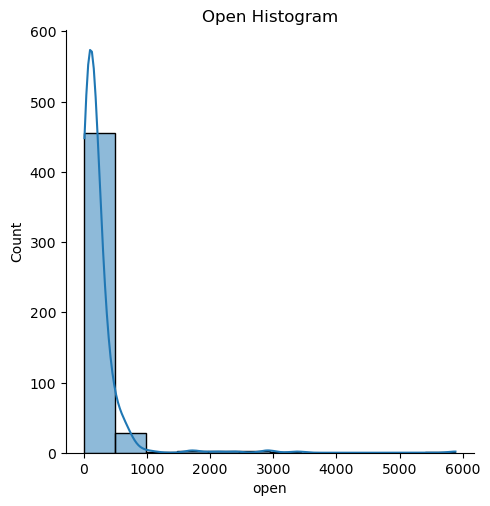

In [143]:
sns.displot(stockr_df['open'], kde = True, bins = 12).set(title='Open Histogram') 

In [144]:
# Find data at the end of the tail (>1000)
stockr_df[stockr_df.open > 1000]

,symbol,open,high,low,close,volume,exchange,date
22,GOOGL,2921.0000,2933.9700,2897.0400,2897.0400,906200.0,XNAS,2021-12-31
23,GOOG,2910.8800,146.3650,144.6775,144.6795,16941540.0,XNAS,2021-12-31
25,AMZN,3379.1201,3387.0000,3331.1699,3334.3401,2387300.0,XNAS,2021-12-31
54,AZO,2083.6899,2107.8999,2069.3701,2096.3899,105700.0,XNYS,2021-12-31
70,BKNG,2391.1499,2417.4199,2383.7500,2399.2300,182300.0,XNAS,2021-12-31
102,CMG,1746.0900,1761.8900,1744.1300,1748.2500,104300.0,XNYS,2021-12-31
306,MTD,1699.4900,1710.9600,1696.9000,1697.2100,51900.0,XNYS,2021-12-31
342,NVR,5884.1001,5917.7002,5850.5000,5908.8701,6300.0,XNYS,2021-12-31
437,TSLA,1073.4399,1082.0000,1054.5900,1056.7800,13528700.0,XNAS,2021-12-31


In [145]:
# Outlier found for GOOG
# Copy high, low, and close from GOOGL affiliated stock as reference point
stockr_df.at[23,'high'] = stockr_df.at[22,'high']
stockr_df.at[23,'low'] = stockr_df.at[22,'low']
stockr_df.at[23,'close'] = stockr_df.at[22,'close']
stockr_df.iloc[23]

symbol            GOOG
open           2910.88
high           2933.97
low            2897.04
close          2897.04
volume      16941540.0
exchange          XNAS
date        2021-12-31
Name: 23, dtype: object

### Close

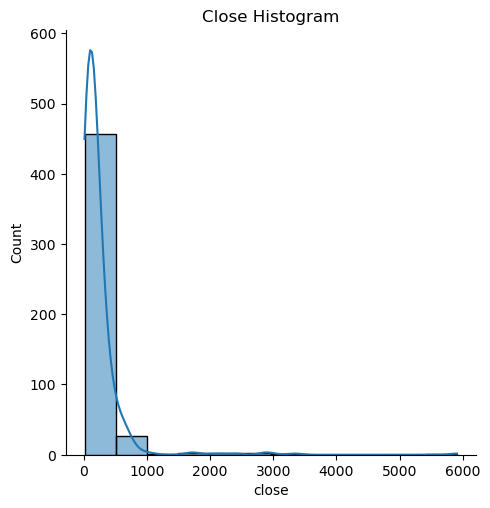

In [146]:
sns.displot(stockr_df['close'], kde = True, bins = 12).set(title='Close Histogram') 

In [147]:
# Check outliers that were not already viewed in open
stockr_df[(stockr_df.close > 1000) & (stockr_df.open < 1000)]

,symbol,open,high,low,close,volume,exchange,date


### High

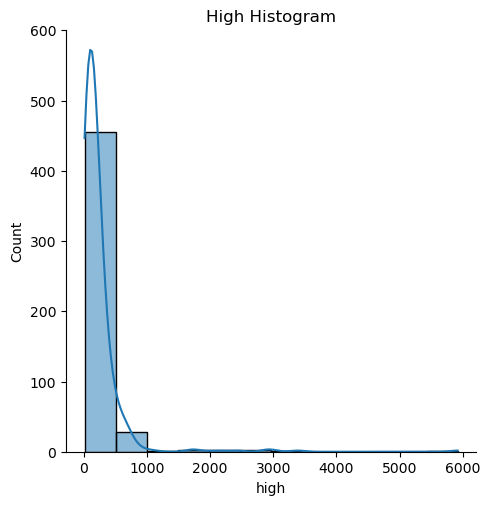

In [148]:
sns.displot(stockr_df['high'], kde = True, bins = 12).set(title='High Histogram') 

In [149]:
# Check outliers that were not already viewed in open
stockr_df[(stockr_df.high > 1000) & (stockr_df.open < 1000)]

,symbol,open,high,low,close,volume,exchange,date


### Low

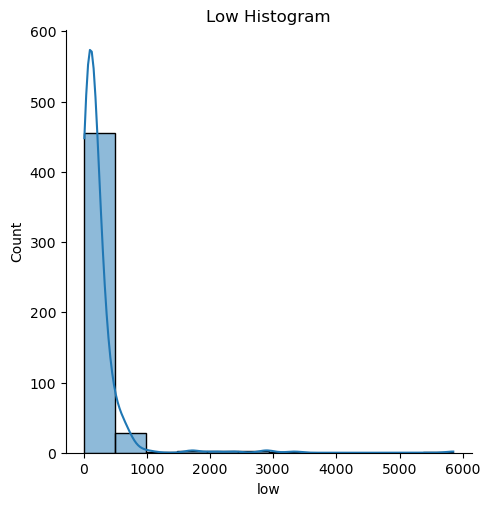

In [150]:
sns.displot(stockr_df['low'], kde = True, bins = 12).set(title='Low Histogram') 

In [151]:
# Check outliers that were not already viewed in open
stockr_df[(stockr_df.low > 1000) & (stockr_df.open < 1000)]

,symbol,open,high,low,close,volume,exchange,date


### Close

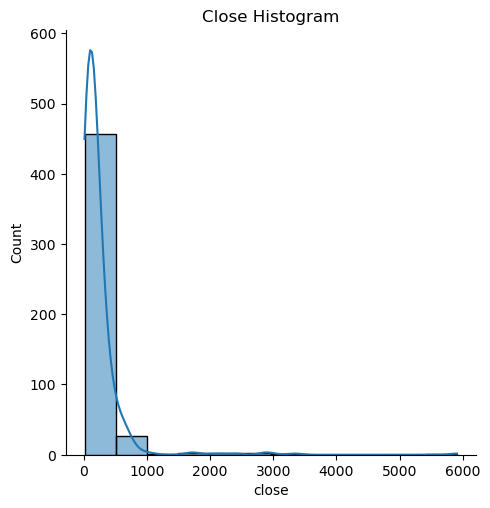

In [152]:
sns.displot(stockr_df['close'], kde = True, bins = 12).set(title='Close Histogram') 

In [123]:
# Check outliers that were not already viewed in open
stockr_df[(stockr_df.close > 1000) & (stockr_df.open < 1000)]

,symbol,open,high,low,close,volume,exchange,date,diff


### Volume

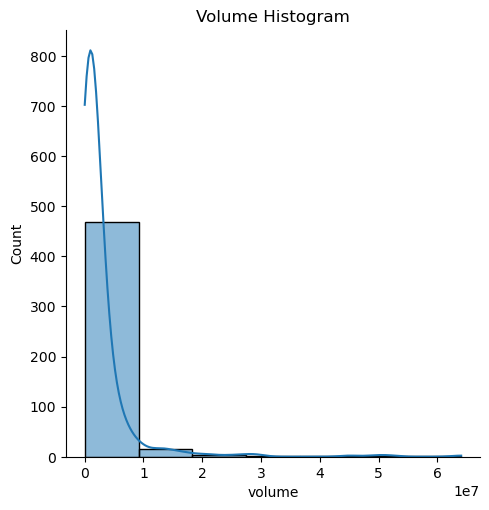

In [153]:
sns.displot(stockr_df['volume'], kde = True, bins = 7).set(title='Volume Histogram') 

In [154]:
# Check outliers that were not already viewed in open
# No significant outliers found
stockr_df[(stockr_df.volume > 20000000) & (stockr_df.open < 1000)]

,symbol,open,high,low,close,volume,exchange,date
27,AMD,146.160,148.61,143.55,143.90,49448144.0,XNAS,2021-12-31
29,AAL,18.070,18.36,17.93,17.96,20632600.0,XNAS,2021-12-31
44,AAPL,178.085,179.23,177.26,177.57,64062262.0,XNAS,2021-12-31
51,T,24.720,24.83,24.57,24.60,45000600.0,XNYS,2021-12-31
58,BAC,44.520,44.72,44.28,44.49,24239600.0,XNYS,2021-12-31
86,CCL,20.510,20.77,20.02,20.12,29323300.0,XNYS,2021-12-31
199,F,20.460,21.01,20.46,20.77,51798100.0,XNYS,2021-12-31
338,NCLH,20.870,21.19,20.40,20.74,20822800.0,XNYS,2021-12-31
341,NVDA,296.740,300.30,293.31,294.11,26628500.0,XNAS,2021-12-31
362,PFE,58.530,59.80,58.44,59.05,28535400.0,XNYS,2021-12-31


### Exchange

In [106]:
# Get unique values of exchange
set(stockr_df['exchange'])

{'ARCX', 'XCBO', 'XNAS', 'XNYS'}

[Text(0.5, 1.0, 'Exchange Count')]

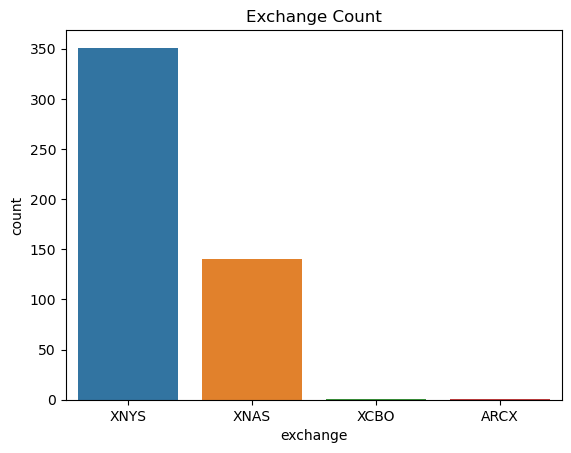

In [108]:
# XNYS and XNAS appear to be the most popular exchange types
# No significant outliers
sns.countplot(x ='exchange', data = stockr_df).set(title='Exchange Count') 

### Date

In [109]:
# Only one value
# No outliers
set(stockr_df['date'])

{datetime.date(2021, 12, 31)}

After reviewing potential outliers in Step 5, GOOG showed values that did not fit the case. The values were replace with the alternate GOOGL.

## Step 6: New Column for Open vs Close Difference

In [155]:
stockr_df['diff'] = stockr_df['close'] - stockr_df['open']

In Step 6, I created a new column to store the difference between open and close.

# Summary

In [157]:
stockr_df.head(10)

,symbol,open,high,low,close,volume,exchange,date,diff
0,MMM,177.53,178.35,176.5100,177.63,1414600.0,XNYS,2021-12-31,0.10
1,AOS,85.13,86.25,85.1300,85.85,966600.0,XNYS,2021-12-31,0.72
2,ABT,141.00,141.77,140.7200,140.74,3271000.0,XNYS,2021-12-31,-0.26
3,ABBV,136.04,136.21,135.3000,135.40,3962700.0,XNYS,2021-12-31,-0.64
4,ACN,412.70,416.95,412.1096,414.55,1163448.0,XNYS,2021-12-31,1.85
5,ATVI,67.32,67.64,66.3000,66.53,9471800.0,XNAS,2021-12-31,-0.79
6,ADM,66.70,67.76,66.6000,67.59,1330500.0,XNYS,2021-12-31,0.89
7,ADBE,570.00,570.17,565.0700,567.06,1581400.0,XNAS,2021-12-31,-2.94
8,ADP,245.45,247.75,244.5900,246.58,884200.0,XNAS,2021-12-31,1.13
9,AAP,237.00,240.97,235.2200,239.88,676100.0,XNYS,2021-12-31,2.88


Marketstack utilizes multiple high-authority market data providers as the source for the API. The analysis above is reliant on the historical and current data has been sourced correctly by these entities. In the cleaning process, I chose to replace the open, high, low, close, and volume values if an adjusted value was available. The adjusted value takes into considerations other factors outside of the normal stock market hours. There are ethical complications involved with this considering the value may not be what was reported on December 31, 2021. For the value of the stock GOOG, I replaced the values with GOOGL as the adjusted values appeared incorrect. The difference calculated by the open and close is only calculated for one day and may not be representative of the entire year.